## Currency prediction with ARIMA.

### Описание проекта

На основе данных о курсе доллара по отношению к рублю попробуем построить прогноз на каждый день на месяц вперед от конца данных. Для прогнозирования курса доллара будем использовать прогнозирующую модель ARIMA из библиотеки statsmodels.

### Исходные данные

Данные о валютной паре 'доллар/рубль' были взяты с сайта компании `Финам` и представляют собой среднедневной курс доллара на бирже в период с января 2019 года по конец апреля 2020 года.  

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa as ts
import warnings
import matplotlib.pyplot as plt
%pylab inline
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


Подготовим и проанализируем имеющиеся данные о курсе доллара.

In [2]:
currency_data = pd.read_csv('USDRUB_190101_200430.csv', sep=';', usecols=['<DATE>','<CLOSE>'], index_col=['<DATE>'], parse_dates= True, dayfirst=True)
currency_data.head()
currency_data.shape

,<CLOSE>
<DATE>,
2019-01-01,69.7045
2019-01-02,68.9165
2019-01-03,68.7099
2019-01-04,67.5415
2019-01-05,67.6321


(446, 1)

Заполним пропущенные значения данных о курсе валюты по тем дням, когда не было торгов на бирже. В качестве значения для заполнения выберем значение курса валюты с соседней даты.

In [3]:
currency_data.index.name = 'Date'
currency_data.columns = ['USD']

In [4]:
currency_data.index = pd.to_datetime(currency_data.index)

In [5]:
new_dates = pd.date_range(currency_data.index.min(), currency_data.index.max())

In [6]:
currency_data = currency_data.reindex(new_dates, method = 'nearest')

In [7]:
currency_data.head()
currency_data.shape

,USD
2019-01-01,69.7045
2019-01-02,68.9165
2019-01-03,68.7099
2019-01-04,67.5415
2019-01-05,67.6321


(486, 1)

### 1. Прогнозирующая модель ARIMA.

#### Произведем визуальный анализ ряда.

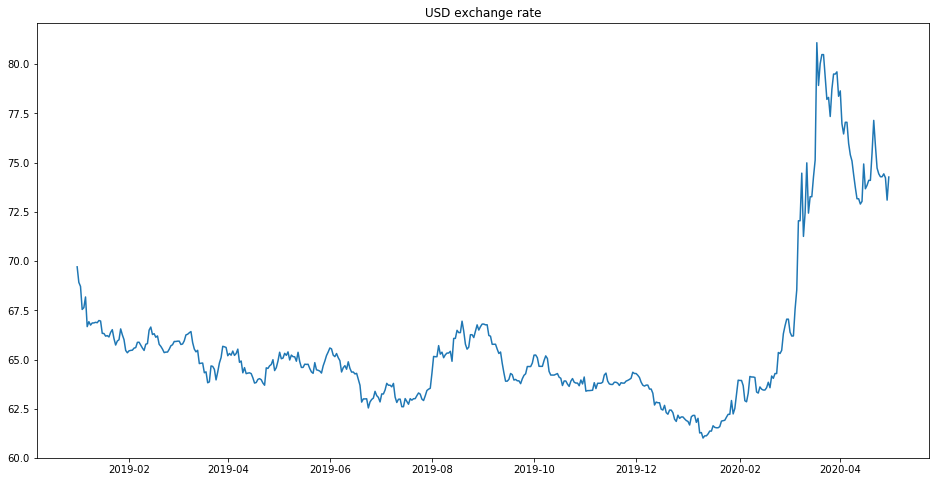

In [8]:
plt.figure(figsize(16,8))
plt.plot(currency_data)
plt.title("USD exchange rate")

#### Посмотрим на автокорреляционную и частичную автокорреляционную функцию исходного ряда.

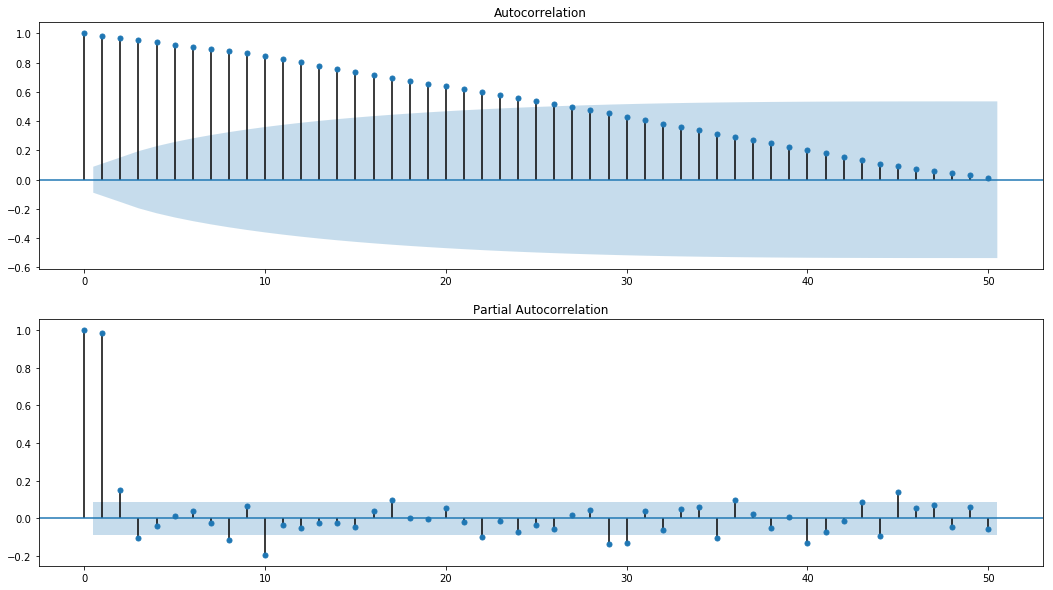

In [9]:
_ = plt.figure(figsize=(18,10))
ax_1 = plt.subplot(2,1,1)
_ = sm.graphics.tsa.plot_acf(currency_data.USD.values.squeeze(), lags=50, ax=ax_1)
ax_2 = plt.subplot(2,1,2)
_ = sm.graphics.tsa.plot_pacf(currency_data.USD.values.squeeze(), lags=50, ax=ax_2)

По графику автокорреляционной функции видно, что данные о курсе валюты имеют тренд.

#### Проверим стационарность ряда и осуществим STL-декомпозиция ряда:

Критерий Дики-Фулера p=0.384964


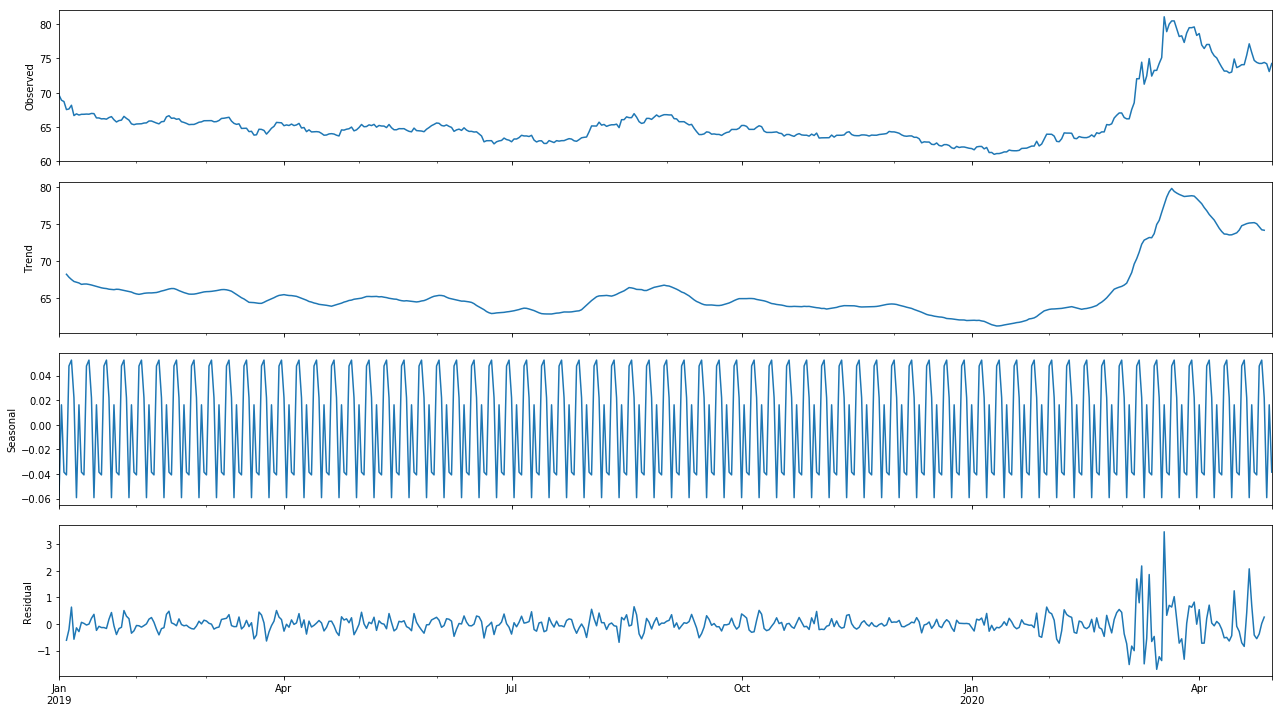

In [10]:
_ = plt.figure(figsize(18,10))
_ = sm.tsa.seasonal_decompose(currency_data.USD).plot()
print("Критерий Дики-Фулера p=%f" % sm.tsa.stattools.adfuller(currency_data.USD)[1])

Из визуального анализа ряда видно, что ряд имеет тренд, сезонность. Критерий Дики-Фулера не отвергает нулевую гипотезу о нестационарности ряда. 
Самая главная особенность имеющегося ряда заключается в том, что он имеет увеличивающуюся во времени дисперсию (гетероскедатичность). Ряды с такими свойствами дисперсии могут быть описаны классом моделей ARCH (AutoRegressive Conditional Heteroscedasticity), но попробуем предсказать значение ряда с использованием прогнозирующих моделей класса ARIMA.

#### Выбор порядка дифференцирования 

Критерий Дики-Фуллера не отвергает гипотезу нестационарности.  Для преобзования ряда к стационарному попробуем обычное дифференцирование. Затем сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность.

Критерий Дики-Фуллера: p=0.000360


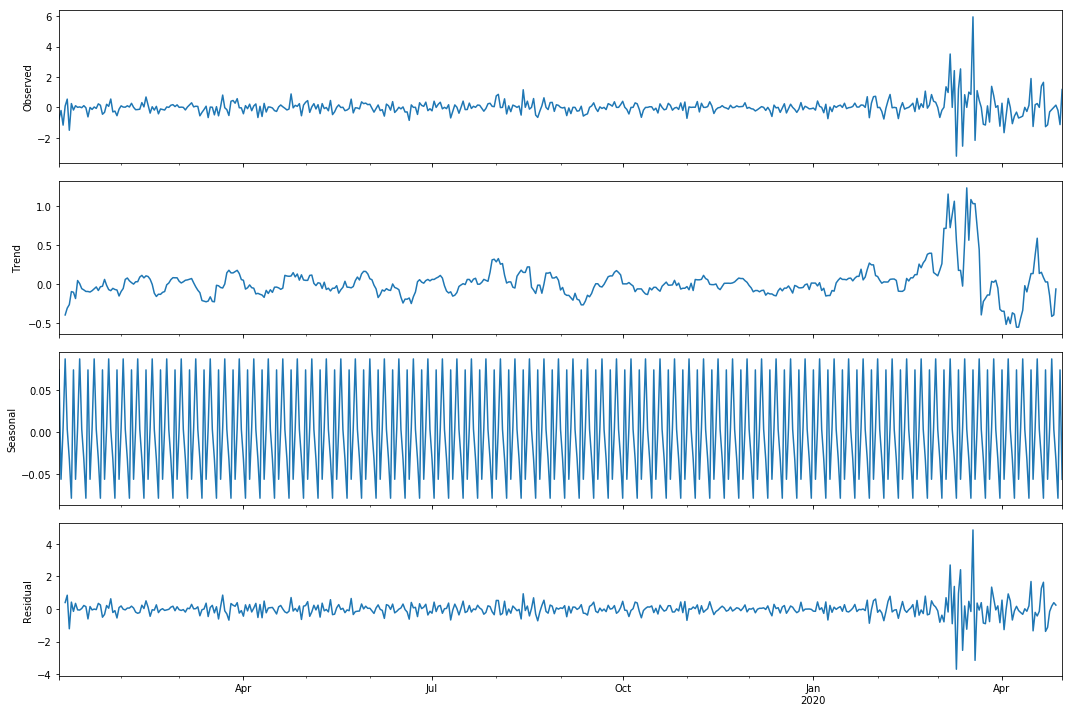

In [11]:
difference_row = currency_data.USD.diff(periods=1).dropna()
_ = plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(difference_row).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(difference_row)[1])

Критерий Дики Фулера уверенно отвергает нулевую гипотезу о нестационарности ряда.

#### Выбор начальных приближений для p,q,P,Q

Посмотрим на автокорреляционную и частичную автокорреляционную функцию продифференцированного ряда.

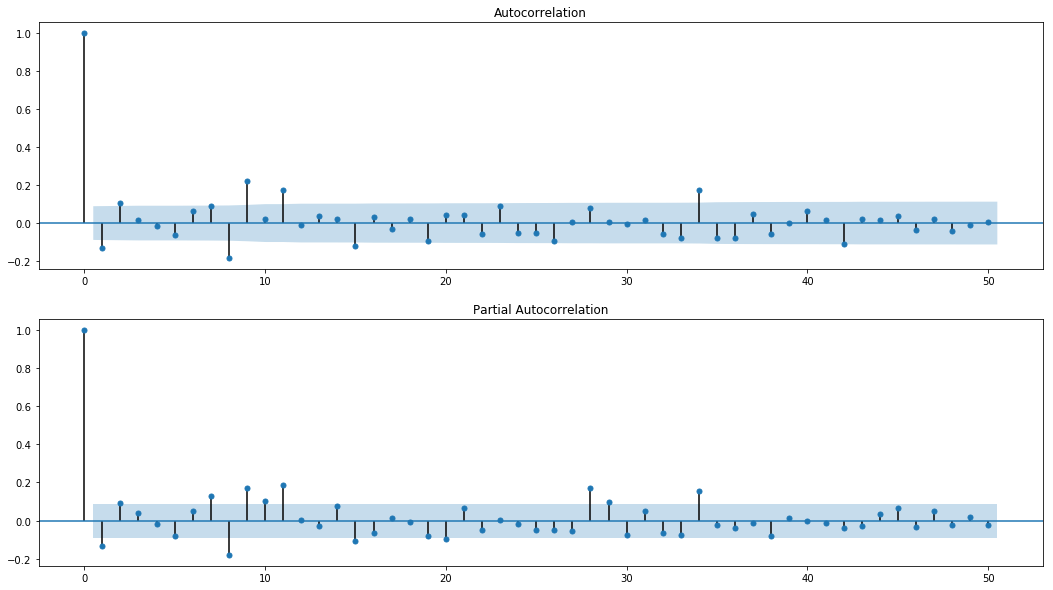

In [12]:
_ = plt.figure(figsize(18,10))
ax_1 = plt.subplot(2,1,1)
_ = sm.graphics.tsa.plot_acf(difference_row.values.squeeze(), lags=50, ax=ax_1)
ax_2 = plt.subplot(2,1,2)
_ = sm.graphics.tsa.plot_pacf(difference_row.values.squeeze(), lags=50, ax=ax_2)

Выбор начальных приближений для построения модели.
Начальные приближения: q = 9, p = 9, посмотрим какая модель имеет меньшее значение критерия Акаике.

In [13]:
d = 1
ps = list(range(10))
qs = list(range(10))

In [14]:
parameters_list = list(itertools.product(ps, qs))

#### Обучим на всех данных, сравним модели-кандидаты и  выберем  лучшую.

In [137]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(currency_data, order=(param[0], d, param[1]), seasonal_order=(0, 0, 0, 0)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong paramaters for model:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1min 21s


In [138]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

   parameters         aic
98     (9, 8)  764.135084
89     (8, 9)  764.490496
99     (9, 9)  766.880475
79     (7, 9)  773.239915
59     (5, 9)  774.192402
..        ...         ...
31     (3, 1)  834.055910
1      (0, 1)  834.554207
51     (5, 1)  834.721229
41     (4, 1)  835.548196
0      (0, 0)  839.541365

[100 rows x 2 columns]


Выводим информацию о лучшей предсказательной модели ARIMA

In [139]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                    USD   No. Observations:                  486
Model:               SARIMAX(9, 1, 8)   Log Likelihood                -364.068
Date:                Wed, 13 May 2020   AIC                            764.135
Time:                        16:03:06   BIC                            839.450
Sample:                    01-01-2019   HQIC                           793.727
                         - 04-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8272      0.070     11.825      0.000       0.690       0.964
ar.L2         -0.2133      0.092     -2.324      0.020      -0.393      -0.033
ar.L3         -0.1548      0.083     -1.857      0.0

Выберем модель ARIMA с параметрами p=9, q=8.

In [15]:
selected_model = sm.tsa.statespace.SARIMAX(currency_data, order=(9, d, 8), seasonal_order=(0, 0, 0, 0)).fit(disp=-1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### Анализ остатков построенной модели

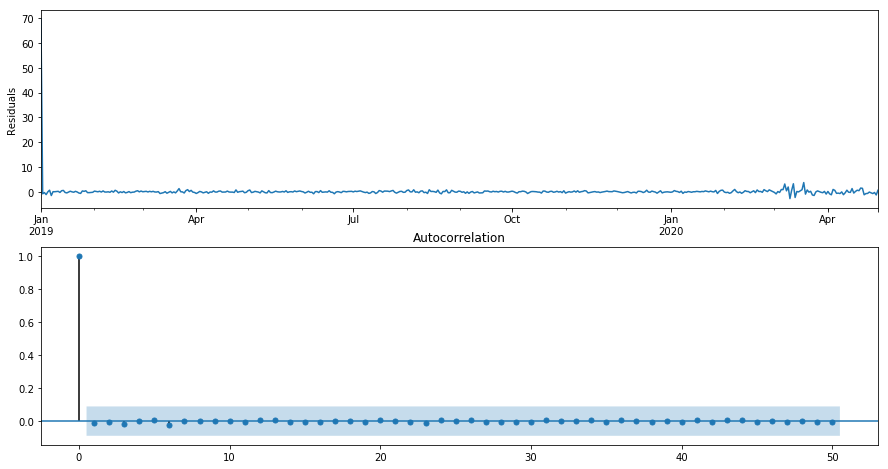

Критерий Стьюдента: p=0.310971
Критерий Дики-Фуллера: p=0.000000


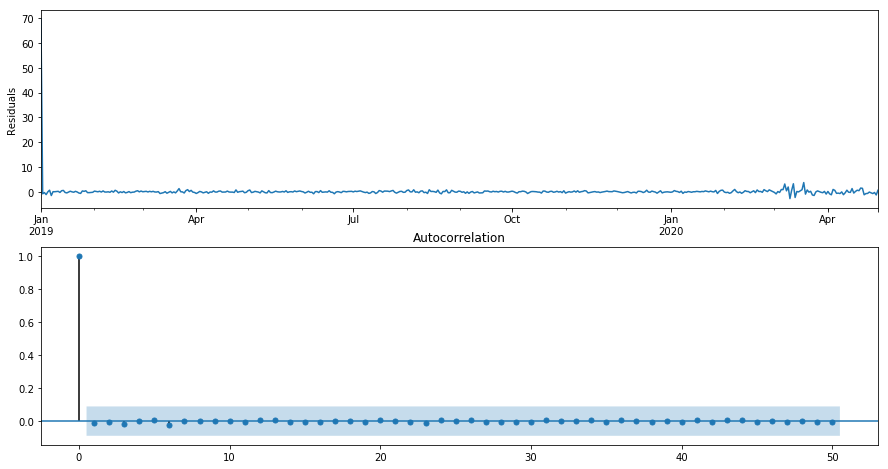

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
selected_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(selected_model.resid.values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(selected_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(selected_model.resid)[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Сделаем прогноз по построенной модели.

#### Сделаем предсказание с использованием выбранной модели.

Для начала определим метрику качества модели.
Mean Absolute Percentage Error - метрика качества аналогичная MAE(Mean Absolute Error), но измеряющая значения в процентах. Данную метрику удобно использовать для объяснения заказчику качества прогноза, изменяется в диапазоне $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

Определим функцию для подсчета метрики MAPE.

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Определим функцию для построения прогноза модели и отрисовки графика с построенными значениями.

In [20]:
def plotARIMA(series, model, n_steps, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted ARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][d:], data['arima_model'][d:])
    

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);

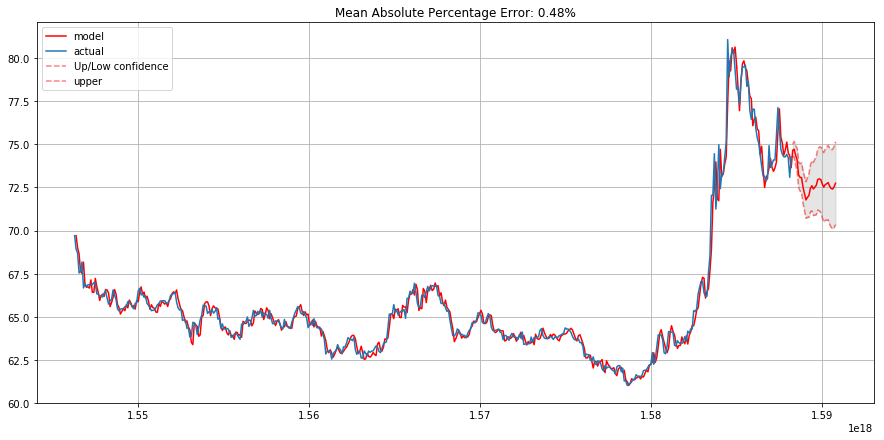

In [21]:
plotARIMA(currency_data, selected_model, 30, alpha=0.5)

Из результирующего графика прогноза видно, что модель класса ARIMA(9,1,8) сумела сделать нетривиальный прогноз по курсу доллара со средней абсолютной ошибкой в 0.5%. Конечно же модель не берет в расчет экономические события, которые влияют на динамику курса. К тому же при увеличении горизонта прогнозирования предсказанные значения ряда становятся больше похожими на шум, колеблющийся вокруг спрогнозированной линии тренда.